In [ ]:
%pip install jaxopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 6.0 MB/s eta 0:00:00


In [ ]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import numpy as np
import optax
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import jaxopt
import random

# Define clipping value for numerical for stability
MIN_VALUE = 1e-6

# Seed for reproducibility
SEED = 0

PRICE_SCALE = 10
MAX_SUPPLY = 10

In [ ]:
def get_linear_marshallian_demand(prices, budget, valuations):
    max_bang_buck_goods = (valuations/prices >= np.max(valuations/prices))
    cost = max_bang_buck_goods.T @ prices
    denom = jnp.clip(cost, a_min = MIN_VALUE)
    demand = max_bang_buck_goods*(budget/denom)
    cliped_demand  = jnp.clip(demand, 0, 2*MAX_SUPPLY)
    return  cliped_demand

def get_CD_marshallian_demand(prices, budget, valuations):
    normalized_vals = valuations / np.sum(valuations)
    denom = jnp.clip(prices, a_min = MIN_VALUE)
    demand = budget * (normalized_vals/denom)
    cliped_demand  = jnp.clip(demand, 0, 2*MAX_SUPPLY)
    return cliped_demand

def get_leontief_marshallian_demand(prices, budget, valuations):
    denom = jnp.clip(prices.T @ valuations, a_min = MIN_VALUE)
    demand = budget * (valuations/denom)
    cliped_demand  = jnp.clip(demand, 0, 2*MAX_SUPPLY)
    return cliped_demand


def get_ces_marshallian_demand(prices, budget, valuations, rho):
    v = jnp.power(valuations, 1/(1-rho))
    p_num = jnp.power(prices, 1/(rho-1))
    p_denom = jnp.power(prices, rho/(rho-1))
    denom = jnp.clip(v.T @ p_denom, a_min = MIN_VALUE)
    num = (v*p_num)
    demand = budget * (num/denom)
    cliped_demand  = jnp.clip(demand, 0, 2*MAX_SUPPLY)
    return cliped_demand


def get_walrasian_violation(prices, ex_demand):
    return jnp.max(jnp.clip(ex_demand, a_min = 0)) + jnp.abs(prices.T @ ex_demand)

In [ ]:
def tatonnement(consendows, valuations, rhos, init_prices, step_size, num_horizons, store_history = False):

    @jax.jit
    def excess_demand(prices):
        # Linear consumers' demands
        consendows_linear = consendows["linear"]
        valuations_linear = valuations["linear"]
        budgets_linear = consendows_linear @ prices
        demands_linear = jax.vmap(get_linear_marshallian_demand, in_axes=(None, 0, 0))(prices, budgets_linear, valuations_linear)
        # print(f"demands linear: {demands_linear}")
        # print(f"Endowments linear: {consendows_linear}")
        # print(f"excess demand linear: {jnp.sum(demands_linear, axis=0) - jnp.sum(consendows_linear, axis=0)}")

        # Cobb-Douglas consumers' demands
        consendows_cd = consendows["cd"]
        valuations_cd = valuations["cd"]
        budgets_cd = consendows_cd @ prices
        demand_cd = jax.vmap(get_CD_marshallian_demand, in_axes=(None, 0, 0))(prices, budgets_cd, valuations_cd)
        # print(f"prices: {prices}")
        # print(f"valuations: {valuations_cd}")
        # print(f"demands cd: {demand_cd}")
        # print(f"Endowments cd: {consendows_cd}")
        # print(f"excess demand cd: {jnp.sum(demand_cd, axis=0) - jnp.sum(consendows_cd, axis=0)}")

        # Leontief consumers' demands
        consendows_leontief = consendows["leontief"]
        valuations_leontief = valuations["leontief"]
        budgets_leontief = consendows_leontief @ prices
        demands_leontief = jax.vmap(get_leontief_marshallian_demand, in_axes=(None, 0, 0))(prices, budgets_leontief, valuations_leontief)
        # print(f"demands leontief: {demands_leontief}")
        # print(f"Endowments leontief: {consendows_leontief}")
        # print(f"prices: {prices}")
        # print(f"budgets: {budgets_leontief}")
        # print(f"valuations: {valuations_leontief}")
        # print(f"excess demand leontief: {jnp.sum(demands_leontief, axis=0) - jnp.sum(consendows_leontief, axis=0)}")

        # CES consumers' demand
        consendows_ces = consendows["ces"]
        valuations_ces = valuations["ces"]
        budgets_ces = consendows_ces @ prices
        demands_ces = jax.vmap(get_ces_marshallian_demand, in_axes=(None, 0, 0, 0))(prices, budgets_ces, valuations_ces, rhos)
        # print(f"demands ces: {demands_ces}")
        # print(f"Endowments ces: {consendows_ces}")
        # print(f"excess demand ces: {jnp.sum(demands_ces, axis=0) - jnp.sum(consendows_ces, axis=0)}")

        aggregate_demand = jnp.sum(demands_linear, axis=0) + jnp.sum(demand_cd, axis=0) + jnp.sum(demands_leontief, axis=0) + jnp.sum(demands_ces, axis=0)
        aggregate_supply = jnp.sum(consendows_linear, axis=0) + jnp.sum(consendows_cd, axis=0) + jnp.sum(consendows_leontief, axis=0) + jnp.sum(consendows_ces, axis=0)
        ex_demand = aggregate_demand - aggregate_supply
        # print(f"excess demand: {ex_demand}")

        return ex_demand

    # Optional data stored
    prices = init_prices
    prices_history = []
    ex_demand_history = []

    # stored data
    violation_history = [get_walrasian_violation(prices, excess_demand(prices))]

    @jax.jit
    def tatonnement_step(prices):

        # step
        ex_demand = excess_demand(prices)
        prices = jnp.clip(prices + step_size * ex_demand, a_min = 0, a_max = PRICE_SCALE)

        return (prices, ex_demand)

    for num_horizon in range(num_horizons):
        print(f"******** Tâtonnement step {num_horizon} ********")



        prices, ex_demand = tatonnement_step(prices)
        violation_history.append(get_walrasian_violation(prices, ex_demand))
        print(f"Violation: {violation_history[-1]}")

        if store_history:
            prices_history.append(prices)
            ex_demand_history.append(ex_demand)



    return prices_history, ex_demand_history, violation_history


In [ ]:
def extratatonnement(consendows, valuations, rhos, init_prices, step_size, num_horizons, store_history = False):

    @jax.jit
    def excess_demand(prices):
        # Linear consumers' demands
        consendows_linear = consendows["linear"]
        valuations_linear = valuations["linear"]
        budgets_linear = consendows_linear @ prices
        demands_linear = jax.vmap(get_linear_marshallian_demand, in_axes=(None, 0, 0))(prices, budgets_linear, valuations_linear)
        # print(f"demands linear: {demands_linear}")
        # print(f"Endowments linear: {consendows_linear}")
        # print(f"excess demand linear: {jnp.sum(demands_linear, axis=0) - jnp.sum(consendows_linear, axis=0)}")

        # Cobb-Douglas consumers' demands
        consendows_cd = consendows["cd"]
        valuations_cd = valuations["cd"]
        budgets_cd = consendows_cd @ prices
        demand_cd = jax.vmap(get_CD_marshallian_demand, in_axes=(None, 0, 0))(prices, budgets_cd, valuations_cd)
        # print(f"prices: {prices}")
        # print(f"valuations: {valuations_cd}")
        # print(f"demands cd: {demand_cd}")
        # print(f"Endowments cd: {consendows_cd}")
        # print(f"excess demand cd: {jnp.sum(demand_cd, axis=0) - jnp.sum(consendows_cd, axis=0)}")

        # Leontief consumers' demands
        consendows_leontief = consendows["leontief"]
        valuations_leontief = valuations["leontief"]
        budgets_leontief = consendows_leontief @ prices
        demands_leontief = jax.vmap(get_leontief_marshallian_demand, in_axes=(None, 0, 0))(prices, budgets_leontief, valuations_leontief)
        # print(f"demands leontief: {demands_leontief}")
        # print(f"Endowments leontief: {consendows_leontief}")
        # print(f"prices: {prices}")
        # print(f"budgets: {budgets_leontief}")
        # print(f"valuations: {valuations_leontief}")
        # print(f"excess demand leontief: {jnp.sum(demands_leontief, axis=0) - jnp.sum(consendows_leontief, axis=0)}")

        # CES consumers' demand
        consendows_ces = consendows["ces"]
        valuations_ces = valuations["ces"]
        budgets_ces = consendows_ces @ prices
        demands_ces = jax.vmap(get_ces_marshallian_demand, in_axes=(None, 0, 0, 0))(prices, budgets_ces, valuations_ces, rhos)
        # print(f"demands ces: {demands_ces}")
        # print(f"Endowments ces: {consendows_ces}")
        # print(f"excess demand ces: {jnp.sum(demands_ces, axis=0) - jnp.sum(consendows_ces, axis=0)}")

        aggregate_demand = jnp.sum(demands_linear, axis=0) + jnp.sum(demand_cd, axis=0) + jnp.sum(demands_leontief, axis=0) + jnp.sum(demands_ces, axis=0)
        aggregate_supply = jnp.sum(consendows_linear, axis=0) + jnp.sum(consendows_cd, axis=0) + jnp.sum(consendows_leontief, axis=0) + jnp.sum(consendows_ces, axis=0)
        ex_demand = aggregate_demand - aggregate_supply
        # print(f"excess demand: {ex_demand}")

        return ex_demand

    # Optional data stored
    prices = init_prices
    prices_half_history = []
    prices_full_history = []
    ex_demand_half_history = []
    ex_demand_full_history = []

    # Data stored
    lip_coef_history = []
    half_step_violation_history = [get_walrasian_violation(prices, excess_demand(prices))]
    full_step_violation_history = [get_walrasian_violation(prices, excess_demand(prices))]

    @jax.jit
    def extratatonnement_step(prices):

        # Half step
        ex_demand_half = excess_demand(prices)
        prices_half = jnp.clip(prices + step_size * ex_demand_half, a_min = 0, a_max = PRICE_SCALE)


        # Full step
        ex_demand_full = excess_demand(prices_half)
        prices_full = jnp.clip(prices + step_size * ex_demand_full, a_min = 0, a_max = PRICE_SCALE)

        return (prices_half, prices_full, ex_demand_half, ex_demand_full)



    for num_horizon in range(num_horizons):
        print(f"******** Extratâtonnement step {num_horizon} ********")
        prices_half, prices, ex_demand_half, ex_demand_full = extratatonnement_step(prices)

        if store_history:
            prices_half_history.append(prices_half)
            prices_full_history.append(prices)
            ex_demand_half_history.append(ex_demand_half)
            ex_demand_full_history.append(ex_demand_full)

        # Compute local Lipschitz coefficient
        lip_coef = jnp.linalg.norm(ex_demand_half - ex_demand_full)/jnp.linalg.norm(prices_half - prices)
        lip_coef_history.append(lip_coef)

        half_step_violation_history.append(get_walrasian_violation(prices_half, ex_demand_half))
        full_step_violation_history.append(get_walrasian_violation(prices, ex_demand_full))
        print(f"Half step violation: {half_step_violation_history[-1]}")
        print(f"Full step violation: {full_step_violation_history[-1]}")

    return prices_half_history, prices_full_history, ex_demand_half_history, ex_demand_full_history, half_step_violation_history, full_step_violation_history, lip_coef_history


In [ ]:
def plot_violation_norms(violations_1, violations_2, plot_1_legend = "", plot_2_legend= "", title="", log_scale=False):
    """Plots the Walrasian equilibrium violations of prices over time and superposes 1/sqrt(time).

    Args:
        prices_hist: A list of JAX arrays, where each array represents
                     the price vector at a given time step.
        ex_demand_history: A list of JAX arrays, where each array represents
                            the excess demand vector at a given time step.
    """
    import matplotlib.pyplot as plt
    import jax.numpy as jnp


    # Generate time steps
    time_steps = jnp.arange(1, len(violations_1) + 1)  # Start at 1 to avoid division by zero

    # Calculate 1/sqrt(time) values
    sqrt_decay = jnp.linalg.norm(violations_1[0]) / jnp.sqrt(time_steps)

    # Set up figure with professional styling
    plt.figure(figsize=(6, 4))
    plt.style.use('ggplot')

    # Plot excess demand violations
    plt.plot(time_steps, violations_1, label=plot_1_legend, linewidth=2, color="blue")

    if violations_2 != []:
        plt.plot(time_steps, violations_2, label=plot_2_legend, linewidth=2, color="red")

    # Plot 1/sqrt(time) for comparison
    plt.plot(time_steps, sqrt_decay, label=r"$\frac{1}{\sqrt{t}}$", linestyle="--", color="green", linewidth=2)

    # Add labels, title, and legend with improved styling
    plt.xlabel("Time Step (t)", fontsize=12)
    plt.ylabel(r"$\varepsilon$", fontsize=12)
    plt.title(r"$\varepsilon$-Walrasian Equilibrium Progression of Prices for " + f"{title}", fontsize=12)
    plt.legend(fontsize=10, loc="upper right")

    # Toggle y-axis to log scale if requested
    if log_scale:
        plt.yscale("log")

    # Annotate the final violation value
    final_time_step = len(violations_1) - 1
    final_violation_1 = violations_1[-1]


    if plot_1_legend != "":
        plt.annotate(
            f"Final {plot_1_legend}\n" + r"$\varepsilon =$ " + f"{final_violation_1:.2e}",
            xy=(final_time_step, final_violation_1),
            xytext=(final_time_step - len(violations_1) * 0.4, max(violations_1)* 0.1 ),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            bbox=dict(boxstyle="round,pad=0.1", edgecolor="black", facecolor="white"),
            fontsize=12
        )

    if plot_2_legend != "":
        final_violation_2 = violations_2[-1]
        plt.annotate(
            f"Final {plot_2_legend} value:\n {final_violation_2:.2e}",
            xy=(final_time_step, final_violation_2),
            xytext=(final_time_step - len(violations_2) * 0.1, final_violation_2 * 1.1),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            bbox=dict(boxstyle="round,pad=0.1", edgecolor="black", facecolor="white"),
            fontsize=6
        )

    # Adjust layout for better appearance
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
def init_experiment(seed, num_linear_consumers, num_cd_consumers, num_leontief_consumers, num_ces_subs_consumers, num_ces_compl_consumers, num_goods):
    num_ces_consumers = num_ces_subs_consumers + num_ces_compl_consumers
    num_consumers = num_linear_consumers + num_cd_consumers + num_leontief_consumers + num_ces_subs_consumers + num_ces_compl_consumers

    # Generate key
    key = jax.random.PRNGKey(seed)

    ########################## Generate random endowments ##########################
    key, subkey = jax.random.split(key)
    subkeys = jax.random.split(subkey, 4)

    consendows = {
        "linear": jax.random.uniform(subkeys[0], shape=(num_linear_consumers, num_goods), minval = MIN_VALUE),
        "cd": jax.random.uniform(subkeys[1], shape=(num_cd_consumers, num_goods), minval = MIN_VALUE),
        "leontief": jax.random.uniform(subkeys[2], shape=(num_leontief_consumers, num_goods), minval = MIN_VALUE),
        "ces": jax.random.uniform(subkeys[3], shape=(num_ces_consumers, num_goods), minval = MIN_VALUE)
    }

    #### Normalize endowments so they sum to MAX_SUPPLY across all buyers

    # Calculate the total supply across all consumer types
    aggregate_supply = sum(jnp.sum(endowment, axis = 0, keepdims=True) for endowment in consendows.values())

    # Normalize each consumer type's endowments so the total supply sums to MAX_SUPPLY
    consendows = {
        consumer_type: (MAX_SUPPLY*endowment) / aggregate_supply
        for consumer_type, endowment in consendows.items()
    }

    ########################## Generate random valuations ##########################
    key, subkey = jax.random.split(key)
    subkeys = jax.random.split(subkey, 4)

    valuations = {"linear": jax.random.uniform(subkeys[0], shape=(num_linear_consumers, num_goods), minval = 0),
                "cd": jax.random.uniform(subkeys[1], shape=(num_cd_consumers, num_goods), minval = 0),
                "leontief": jax.random.uniform(subkeys[2], shape=(num_leontief_consumers, num_goods), minval = 0),
                "ces": jax.random.uniform(subkeys[3], shape=(num_ces_consumers, num_goods), minval = 0)
                }

    #################### Generate random substitution parameters ###################
    key, subkey = jax.random.split(key)
    subkeys = jax.random.split(subkey, 2)

    # Substitutes range of substitution parameters
    subs_rho = jax.random.uniform(subkeys[0], shape=(num_ces_subs_consumers,), minval = 0.6, maxval = 0.9)
    compl_rho = jax.random.uniform(subkeys[1], shape=(num_ces_compl_consumers,), minval = -1000, maxval = -1)
    rhos = jnp.concatenate([subs_rho, compl_rho])

    # Substitutes range of substitution parameters

    # Set parameters
    key, subkey = jax.random.split(key)
    init_prices = jax.random.uniform(subkey, shape=(num_goods,), minval = PRICE_SCALE*0.1, maxval = PRICE_SCALE)

    return consendows, valuations, rhos, init_prices

# Experiments

In [ ]:
experiment_results_extratonnement = {f"Experiment {i}":{"Violations": None,
                                                        "Lipschitz Constant": None} for i in range(1,8)}

# Experiment 1

In [ ]:
experiment_title = "Experiment 1"
num_linear_consumers = 0
num_cd_consumers = 0
num_leontief_consumers = 600
num_ces_subs_consumers = 0
num_ces_compl_consumers = 0
num_consumers = num_linear_consumers + num_cd_consumers + num_leontief_consumers + num_ces_subs_consumers + num_ces_compl_consumers
num_goods = 500

consendows, valuations, rhos, init_prices = init_experiment(SEED, num_linear_consumers, num_cd_consumers, num_leontief_consumers, num_ces_subs_consumers, num_ces_compl_consumers, num_goods)

step_size = 10000000/(2*MAX_SUPPLY*num_consumers*num_goods)
num_horizons = 750


# Run Tatonnement
# _, _, tatonn_violation_history =  tatonnement(consendows, valuations, rhos, init_prices, step_size, num_horizons, store_history = False)

# Run Extratonnement
_, _, _, _, half_step_violation_history, full_step_violation_history, lip_coef_history = extratatonnement(consendows, valuations, rhos, init_prices, step_size, num_horizons, store_history = False)


lip_constant = jnp.max(jnp.array(lip_coef_history))

experiment_results_extratonnement[experiment_title]["Violations"] = half_step_violation_history
experiment_results_extratonnement[experiment_title]["Lipschitz Constant"] = lip_constant

print(f"step size: {step_size}")
print(f"Lipschitz constant: {lip_constant}")
print(f"suggested step size: {1/lip_constant}")
print(f"is step condition satisfied: {step_size <= 1/lip_constant}")

******** Extratâtonnement step 0 ********
Half step violation: 44.55358123779297
Full step violation: 0.774501383304596
******** Extratâtonnement step 1 ********
Half step violation: 42.393531799316406
Full step violation: 0.950677752494812
******** Extratâtonnement step 2 ********
Half step violation: 38.413822174072266
Full step violation: 1.0624586343765259
******** Extratâtonnement step 3 ********
Half step violation: 36.339385986328125
Full step violation: 1.1422759294509888
******** Extratâtonnement step 4 ********
Half step violation: 33.916690826416016
Full step violation: 1.1842637062072754
******** Extratâtonnement step 5 ********
Half step violation: 32.392433166503906
Full step violation: 1.2146215438842773
******** Extratâtonnement step 6 ********
Half step violation: 30.166427612304688
Full step violation: 1.2109990119934082
******** Extratâtonnement step 7 ********
Half step violation: 29.04853057861328
Full step violation: 1.2704558372497559
******** Extratâtonnement st

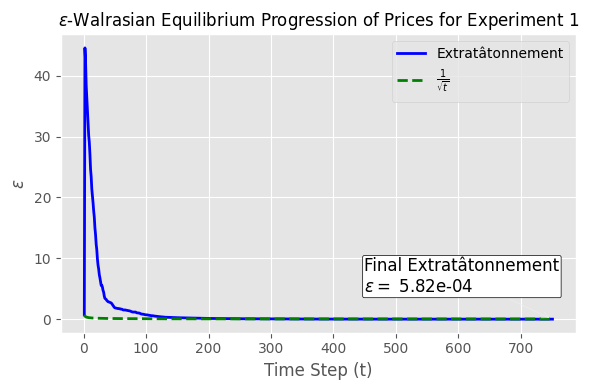

In [ ]:
plot_violation_norms(half_step_violation_history, [], "Extratâtonnement", "", "Experiment 1", False)

# Experiment 2

In [ ]:
experiment_title = "Experiment 2"
num_linear_consumers = 0
num_cd_consumers = 0
num_leontief_consumers = 0
num_ces_subs_consumers = 0
num_ces_compl_consumers = 600
num_consumers = num_linear_consumers + num_cd_consumers + num_leontief_consumers + num_ces_subs_consumers + num_ces_compl_consumers
num_goods = 500

consendows, valuations, rhos, init_prices = init_experiment(SEED, num_linear_consumers, num_cd_consumers, num_leontief_consumers, num_ces_subs_consumers, num_ces_compl_consumers, num_goods)

step_size = 5000000/(2*MAX_SUPPLY*num_consumers*num_goods)
num_horizons = 750


# Run Tatonnement
# _, _, tatonn_violation_history =  tatonnement(consendows, valuations, rhos, init_prices, step_size, num_horizons, store_history = False)

# Run Extratonnement
_, _, _, _, half_step_violation_history, full_step_violation_history, lip_coef_history = extratatonnement(consendows, valuations, rhos, init_prices, step_size, num_horizons, store_history = False)


lip_constant = jnp.max(jnp.array(lip_coef_history))

experiment_results_extratonnement[experiment_title]["Violations"] = half_step_violation_history
experiment_results_extratonnement[experiment_title]["Lipschitz Constant"] = lip_constant

print(f"step size: {step_size}")
print(f"Lipschitz constant: {lip_constant}")
print(f"suggested step size: {1/lip_constant}")
print(f"is step condition satisfied: {step_size <= 1/lip_constant}")

******** Extratâtonnement step 0 ********
Half step violation: 0.6312685012817383
Full step violation: 0.12094689160585403
******** Extratâtonnement step 1 ********
Half step violation: 0.6001054048538208
Full step violation: 0.11490859091281891
******** Extratâtonnement step 2 ********
Half step violation: 0.571497917175293
Full step violation: 0.10945556312799454
******** Extratâtonnement step 3 ********
Half step violation: 0.5455467104911804
Full step violation: 0.10486768931150436
******** Extratâtonnement step 4 ********
Half step violation: 0.5225071907043457
Full step violation: 0.10106532275676727
******** Extratâtonnement step 5 ********
Half step violation: 0.49997153878211975
Full step violation: 0.0973026230931282
******** Extratâtonnement step 6 ********
Half step violation: 0.4801328480243683
Full step violation: 0.0949559360742569
******** Extratâtonnement step 7 ********
Half step violation: 0.46230658888816833
Full step violation: 0.09126117080450058
******** Extratât

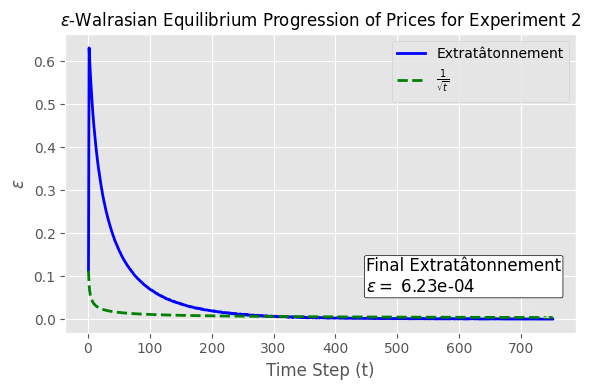

In [ ]:
plot_violation_norms(half_step_violation_history, [], "Extratâtonnement", "", experiment_title, False)

# Experiment 3

In [ ]:
experiment_title = "Experiment 3"
num_linear_consumers = 0
num_cd_consumers = 0
num_leontief_consumers = 0
num_ces_subs_consumers = 600
num_ces_compl_consumers = 0
num_consumers = num_linear_consumers + num_cd_consumers + num_leontief_consumers + num_ces_subs_consumers + num_ces_compl_consumers
num_goods = 500

consendows, valuations, rhos, init_prices = init_experiment(SEED, num_linear_consumers, num_cd_consumers, num_leontief_consumers, num_ces_subs_consumers, num_ces_compl_consumers, num_goods)

step_size = 5000/(2*MAX_SUPPLY*num_consumers*num_goods)
num_horizons = 1000


# Run Tatonnement
# _, _, tatonn_violation_history =  tatonnement(consendows, valuations, rhos, init_prices, step_size, num_horizons, store_history = False)

# Run Extratonnement
_, _, _, _, half_step_violation_history, full_step_violation_history, lip_coef_history = extratatonnement(consendows, valuations, rhos, init_prices, step_size, num_horizons, store_history = False)


lip_constant = jnp.max(jnp.array(lip_coef_history))

experiment_results_extratonnement[experiment_title]["Violations"] = half_step_violation_history
experiment_results_extratonnement[experiment_title]["Lipschitz Constant"] = lip_constant

print(f"step size: {step_size}")
print(f"Lipschitz constant: {lip_constant}")
print(f"suggested step size: {1/lip_constant}")
print(f"is step condition satisfied: {step_size <= 1/lip_constant}")

******** Extratâtonnement step 0 ********
Half step violation: 11001.3876953125
Full step violation: 1101.60595703125
******** Extratâtonnement step 1 ********
Half step violation: 9180.66015625
Full step violation: 823.1678466796875
******** Extratâtonnement step 2 ********
Half step violation: 7815.02734375
Full step violation: 643.2542724609375
******** Extratâtonnement step 3 ********
Half step violation: 6627.75
Full step violation: 585.546142578125
******** Extratâtonnement step 4 ********
Half step violation: 5515.103515625
Full step violation: 516.470458984375
******** Extratâtonnement step 5 ********
Half step violation: 4550.39599609375
Full step violation: 462.74884033203125
******** Extratâtonnement step 6 ********
Half step violation: 3835.091796875
Full step violation: 382.04595947265625
******** Extratâtonnement step 7 ********
Half step violation: 3296.7333984375
Full step violation: 311.8008117675781
******** Extratâtonnement step 8 ********
Half step violation: 2831.2

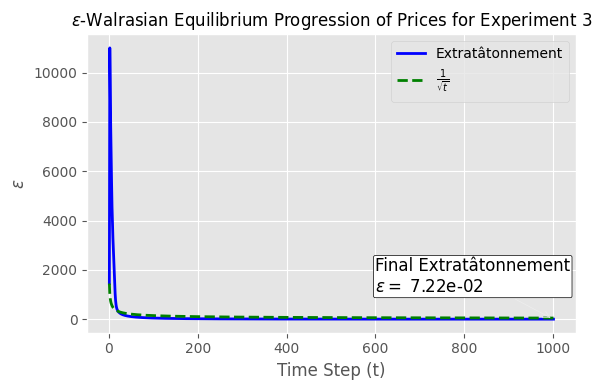

In [ ]:
plot_violation_norms(half_step_violation_history, [], "Extratâtonnement", "", experiment_title, False)

# Experiment 4

In [ ]:
experiment_title = "Experiment 4"
num_linear_consumers = 0
num_cd_consumers = 600
num_leontief_consumers = 0
num_ces_subs_consumers = 0
num_ces_compl_consumers = 0
num_consumers = num_linear_consumers + num_cd_consumers + num_leontief_consumers + num_ces_subs_consumers + num_ces_compl_consumers
num_goods = 500

consendows, valuations, rhos, init_prices = init_experiment(SEED, num_linear_consumers, num_cd_consumers, num_leontief_consumers, num_ces_subs_consumers, num_ces_compl_consumers, num_goods)

step_size = 85000/(2*MAX_SUPPLY*num_consumers*num_goods)
num_horizons = 500


# Run Tatonnement
# _, _, tatonn_violation_history =  tatonnement(consendows, valuations, rhos, init_prices, step_size, num_horizons, store_history = False)

# Run Extratonnement
_, _, _, _, half_step_violation_history, full_step_violation_history, lip_coef_history = extratatonnement(consendows, valuations, rhos, init_prices, step_size, num_horizons, store_history = False)


lip_constant = jnp.max(jnp.array(lip_coef_history))

experiment_results_extratonnement[experiment_title]["Violations"] = half_step_violation_history
experiment_results_extratonnement[experiment_title]["Lipschitz Constant"] = lip_constant

print(f"step size: {step_size}")
print(f"Lipschitz constant: {lip_constant}")
print(f"suggested step size: {1/lip_constant}")
print(f"is step condition satisfied: {step_size <= 1/lip_constant}")

******** Extratâtonnement step 0 ********
Half step violation: 842.0383911132812
Full step violation: 169.09939575195312
******** Extratâtonnement step 1 ********
Half step violation: 544.3424072265625
Full step violation: 95.10726928710938
******** Extratâtonnement step 2 ********
Half step violation: 397.0412292480469
Full step violation: 61.5890998840332
******** Extratâtonnement step 3 ********
Half step violation: 310.8469543457031
Full step violation: 44.20503616333008
******** Extratâtonnement step 4 ********
Half step violation: 254.3020782470703
Full step violation: 33.985713958740234
******** Extratâtonnement step 5 ********
Half step violation: 214.26834106445312
Full step violation: 27.387588500976562
******** Extratâtonnement step 6 ********
Half step violation: 184.379150390625
Full step violation: 22.824363708496094
******** Extratâtonnement step 7 ********
Half step violation: 161.18284606933594
Full step violation: 19.500131607055664
******** Extratâtonnement step 8 **

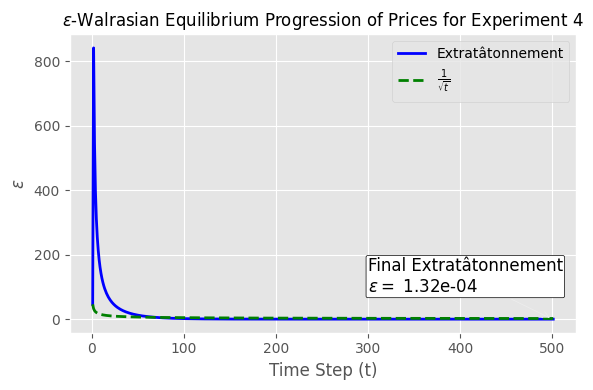

In [ ]:
plot_violation_norms(half_step_violation_history, [], "Extratâtonnement", "", experiment_title, False)

# Experiment 5

In [ ]:
experiment_title = "Experiment 5"
num_linear_consumers = 600
num_cd_consumers = 0
num_leontief_consumers = 0
num_ces_subs_consumers = 0
num_ces_compl_consumers = 0
num_consumers = num_linear_consumers + num_cd_consumers + num_leontief_consumers + num_ces_subs_consumers + num_ces_compl_consumers
num_goods = 500

consendows, valuations, rhos, init_prices = init_experiment(SEED, num_linear_consumers, num_cd_consumers, num_leontief_consumers, num_ces_subs_consumers, num_ces_compl_consumers, num_goods)

step_size = 200/(2*MAX_SUPPLY*num_consumers*num_goods)
num_horizons = 4000


# Run Tatonnement
# _, _, tatonn_violation_history =  tatonnement(consendows, valuations, rhos, init_prices, step_size, num_horizons, store_history = False)

# Run Extratonnement
_, _, _, _, half_step_violation_history, full_step_violation_history, lip_coef_history = extratatonnement(consendows, valuations, rhos, init_prices, step_size, num_horizons, store_history = False)


lip_constant = jnp.max(jnp.array(lip_coef_history))

experiment_results_extratonnement[experiment_title]["Violations"] = half_step_violation_history
experiment_results_extratonnement[experiment_title]["Lipschitz Constant"] = lip_constant

print(f"step size: {step_size}")
print(f"Lipschitz constant: {lip_constant}")
print(f"suggested step size: {1/lip_constant}")
print(f"is step condition satisfied: {step_size <= 1/lip_constant}")

Streaming output truncated to the last 5000 lines.
Full step violation: 31.377010345458984
******** Extratâtonnement step 2335 ********
Half step violation: 43.944156646728516
Full step violation: 39.52357482910156
******** Extratâtonnement step 2336 ********
Half step violation: 43.89897155761719
Full step violation: 40.55358123779297
******** Extratâtonnement step 2337 ********
Half step violation: 43.931365966796875
Full step violation: 40.193843841552734
******** Extratâtonnement step 2338 ********
Half step violation: 43.93281173706055
Full step violation: 31.397930145263672
******** Extratâtonnement step 2339 ********
Half step violation: 43.89181900024414
Full step violation: 40.500579833984375
******** Extratâtonnement step 2340 ********
Half step violation: 43.89801025390625
Full step violation: 40.552162170410156
******** Extratâtonnement step 2341 ********
Half step violation: 43.89175033569336
Full step violation: 40.095672607421875
******** Extratâtonnement step 2342 *****

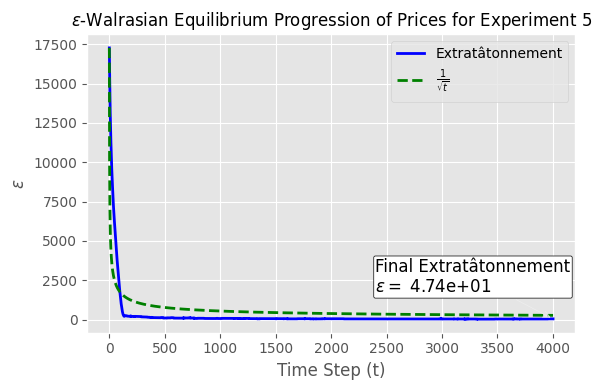

In [ ]:
plot_violation_norms(half_step_violation_history, [], "Extratâtonnement", "", experiment_title, False)

# Experiment 6

In [ ]:
experiment_title = "Experiment 6"
num_linear_consumers = 200
num_cd_consumers = 200
num_leontief_consumers = 200
num_ces_subs_consumers = 200
num_ces_compl_consumers = 200
num_consumers = num_linear_consumers + num_cd_consumers + num_leontief_consumers + num_ces_subs_consumers + num_ces_compl_consumers
num_goods = 500

consendows, valuations, rhos, init_prices = init_experiment(SEED, num_linear_consumers, num_cd_consumers, num_leontief_consumers, num_ces_subs_consumers, num_ces_compl_consumers, num_goods)

step_size = 1500/(2*MAX_SUPPLY*num_consumers*num_goods)
num_horizons = 2000


# Run Tatonnement
# _, _, tatonn_violation_history =  tatonnement(consendows, valuations, rhos, init_prices, step_size, num_horizons, store_history = False)

# Run Extratonnement
_, _, _, _, half_step_violation_history, full_step_violation_history, lip_coef_history = extratatonnement(consendows, valuations, rhos, init_prices, step_size, num_horizons, store_history = False)


lip_constant = jnp.max(jnp.array(lip_coef_history))

experiment_results_extratonnement[experiment_title]["Violations"] = half_step_violation_history
experiment_results_extratonnement[experiment_title]["Lipschitz Constant"] = lip_constant

print(f"step size: {step_size}")
print(f"Lipschitz constant: {lip_constant}")
print(f"suggested step size: {1/lip_constant}")
print(f"is step condition satisfied: {step_size <= 1/lip_constant}")

Streaming output truncated to the last 5000 lines.
Full step violation: 30.224685668945312
******** Extratâtonnement step 335 ********
Half step violation: 56.222076416015625
Full step violation: 40.084449768066406
******** Extratâtonnement step 336 ********
Half step violation: 52.4658203125
Full step violation: 46.2259635925293
******** Extratâtonnement step 337 ********
Half step violation: 56.01028823852539
Full step violation: 30.183141708374023
******** Extratâtonnement step 338 ********
Half step violation: 55.96137619018555
Full step violation: 30.8458251953125
******** Extratâtonnement step 339 ********
Half step violation: 55.86884307861328
Full step violation: 37.72526168823242
******** Extratâtonnement step 340 ********
Half step violation: 55.82239532470703
Full step violation: 36.31153106689453
******** Extratâtonnement step 341 ********
Half step violation: 55.709205627441406
Full step violation: 37.764801025390625
******** Extratâtonnement step 342 ********
Half step vi

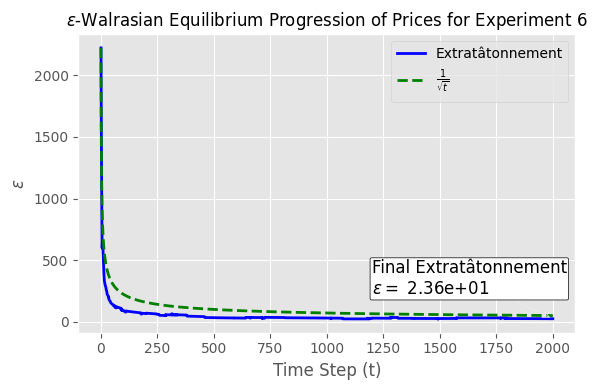

In [ ]:
plot_violation_norms(half_step_violation_history, [], "Extratâtonnement", "", experiment_title, False)

# Experiment 7

In [ ]:
experiment_title = "Experiment 7"
num_linear_consumers = 0
num_cd_consumers = 200
num_leontief_consumers = 200
num_ces_subs_consumers = 200
num_ces_compl_consumers = 200
num_consumers = num_linear_consumers + num_cd_consumers + num_leontief_consumers + num_ces_subs_consumers + num_ces_compl_consumers
num_goods = 500

consendows, valuations, rhos, init_prices = init_experiment(SEED, num_linear_consumers, num_cd_consumers, num_leontief_consumers, num_ces_subs_consumers, num_ces_compl_consumers, num_goods)

step_size = 5000/(2*MAX_SUPPLY*num_consumers*num_goods)
num_horizons = 2000


# Run Tatonnement
# _, _, tatonn_violation_history =  tatonnement(consendows, valuations, rhos, init_prices, step_size, num_horizons, store_history = False)

# Run Extratonnement
_, _, _, _, half_step_violation_history, full_step_violation_history, lip_coef_history = extratatonnement(consendows, valuations, rhos, init_prices, step_size, num_horizons, store_history = False)


lip_constant = jnp.max(jnp.array(lip_coef_history))

experiment_results_extratonnement[experiment_title]["Violations"] = half_step_violation_history
experiment_results_extratonnement[experiment_title]["Lipschitz Constant"] = lip_constant

print(f"step size: {step_size}")
print(f"Lipschitz constant: {lip_constant}")
print(f"suggested step size: {1/lip_constant}")
print(f"is step condition satisfied: {step_size <= 1/lip_constant}")

Streaming output truncated to the last 5000 lines.
Full step violation: 5.369795799255371
******** Extratâtonnement step 335 ********
Half step violation: 8.466048240661621
Full step violation: 5.354872703552246
******** Extratâtonnement step 336 ********
Half step violation: 8.439986228942871
Full step violation: 5.340190410614014
******** Extratâtonnement step 337 ********
Half step violation: 8.414300918579102
Full step violation: 5.326336860656738
******** Extratâtonnement step 338 ********
Half step violation: 8.388283729553223
Full step violation: 5.311600685119629
******** Extratâtonnement step 339 ********
Half step violation: 8.362668991088867
Full step violation: 5.297647953033447
******** Extratâtonnement step 340 ********
Half step violation: 8.3367919921875
Full step violation: 5.283863067626953
******** Extratâtonnement step 341 ********
Half step violation: 8.311134338378906
Full step violation: 5.269530296325684
******** Extratâtonnement step 342 ********
Half step viol

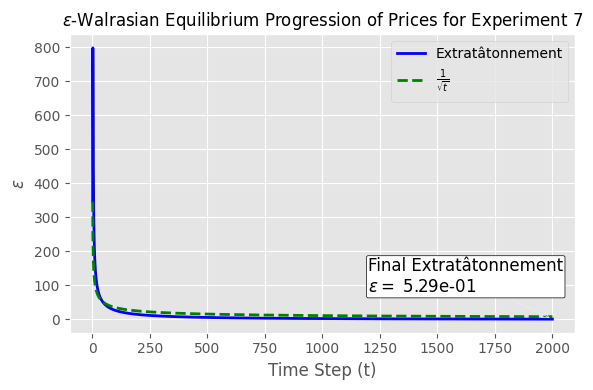

In [ ]:
plot_violation_norms(half_step_violation_history, [], "Extratâtonnement", "", experiment_title, False)

# Scarf Economy Experiment

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import jax.numpy as jnp

def plot_phase_portrait(price_histories, title = ""):
    """
    Plots the phase portrait for multiple trajectories of price dynamics.

    Args:
        price_histories: List of lists, where each sublist is a history of price vectors (JAX arrays with 3 elements).
    """
    fig = plt.figure(figsize=(8, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Add the equilibrium point
    eq_x, eq_y, eq_z = 0.33, 0.33, 0.33
    ax.scatter(eq_x, eq_y, eq_z, color='red', s=30, label='Equilibrium', marker='x')

    for prices_hist in price_histories:
        # Normalize prices and extract trajectories
        trajectory_1 = jnp.array([prices[0] / sum(prices) for prices in prices_hist])
        trajectory_2 = jnp.array([prices[1] / sum(prices) for prices in prices_hist])
        trajectory_3 = jnp.array([prices[2] / sum(prices) for prices in prices_hist])

        # Plot the trajectory in 3D space
        ax.plot3D(trajectory_1, trajectory_2, trajectory_3, linewidth=2, color="green", alpha = 0.6)

        # Add arrows to indicate direction
        for i in range(1, len(trajectory_1), 5):
            ax.quiver(
                trajectory_1[i - 1], trajectory_2[i - 1], trajectory_3[i - 1],
                trajectory_1[i] - trajectory_1[i - 1],
                trajectory_2[i] - trajectory_2[i - 1],
                trajectory_3[i] - trajectory_3[i - 1],
                color="blue", arrow_length_ratio=0.4, alpha = 0.6
            )

        # Annotate final prices
        final_price_1 = trajectory_1[-1]
        final_price_2 = trajectory_2[-1]
        final_price_3 = trajectory_3[-1]

        ax.scatter(final_price_1, final_price_2, final_price_3, color="purple", s=10, label="Final Prices")

        # Add a text box in the top left of the plot with an arrow pointing to the final prices
        bbox_props = dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
        text_x, text_y, text_z = trajectory_1.max()*0.7, trajectory_2.max()*0.94, trajectory_3.max()*0.94
        ax.text(
            text_x,
            text_y,
            text_z,
            f"Equilibrium Prices:\n(1/3, 1/3, 1/3)\nFinal Prices:\n({final_price_1:.2f}, {final_price_2:.2f}, {final_price_3:.2f})",
            fontsize=14,
            color="black",
            bbox=bbox_props
        )
    # Aesthetic improvements
    ax.set_title(f"{title} Price Dynamics in the Scarf Economy", fontsize=16, pad=10)
    ax.set_xlabel("Price of Commodity 1", fontsize=10, labelpad=10)
    ax.set_ylabel("Price of Commodity 2", fontsize=10, labelpad=10)
    ax.set_zlabel("Price of Commodity 3", fontsize=10, labelpad=0)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    # Adjust layout to prevent label cutoff
    fig.subplots_adjust(left=0, right=10, bottom=0, top=0.9)  # Adjust margins if needed
    # plt.tight_layout()
    plt.show()


In [ ]:
num_linear_consumers = 0
num_cd_consumers = 0
num_leontief_consumers = 3
num_ces_consumers = 0
num_consumers = num_leontief_consumers + num_ces_consumers + num_linear_consumers + num_cd_consumers
num_goods = 3


# Generate key
key = jax.random.PRNGKey(0)

########################## Generate random endowments ##########################
key, subkey = jax.random.split(key)
consendows = {
    "linear": jax.random.uniform(subkey, shape=(num_linear_consumers, num_goods), minval = MIN_VALUE),
    "cd": jax.random.uniform(subkey, shape=(num_cd_consumers, num_goods), minval = MIN_VALUE),
    "leontief": jnp.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]),
    "ces": jax.random.uniform(subkey, shape=(num_ces_consumers, num_goods), minval = MIN_VALUE)
}


########################## Generate random valuations ##########################
key, subkey = jax.random.split(key)
valuations = {
    "linear": jax.random.uniform(subkey, shape=(num_linear_consumers, num_goods), minval = MIN_VALUE),
    "cd": jax.random.uniform(subkey, shape=(num_cd_consumers, num_goods), minval = MIN_VALUE),
    "leontief": jnp.array([[1, 1, 0], [0, 1, 1], [1, 0, 1]]),
    "ces": jax.random.uniform(subkey, shape=(num_ces_consumers, num_goods), minval = MIN_VALUE)
}

#################### Generate random substitution parameters ###################
key, subkey = jax.random.split(key)
rhos = jax.random.uniform(subkey, shape=(num_ces_consumers,), minval = -1000, maxval = -1)


# # Set parameters
# key, subkey = jax.random.split(key)
# subkeys = jax.random.split(key, 3)

# init_prices_1 = jax.random.uniform(subkeys[0], shape=(num_goods,), minval = MIN_VALUE)
# init_prices_2 = jax.random.uniform(subkeys[1], shape=(num_goods,), minval = MIN_VALUE)
# init_prices_3 = jax.random.uniform(subkeys[2], shape=(num_goods,), minval = MIN_VALUE)
# Scale prices so that max price is equal to 1 for visibility on graph
# init_prices = init_prices/jnp.max(init_prices)
init_prices_1 = jnp.array([0.33, 0.40, 0.33])
# init_prices_2 = jnp.array([0.33, 0.34, 0.33])
# init_prices_2 = jnp.array([0.33, 0.33, 0.34])


step_size = 7/(2*MAX_SUPPLY*num_consumers*num_goods)
num_horizons = 2000

# Run Tatonnement
tatonn_prices_history_1, _, _ =  tatonnement(consendows, valuations, rhos, init_prices_1, step_size, num_horizons, store_history = True)
# tatonn_prices_history_2, _, _ =  tatonnement(consendows, valuations, rhos, init_prices_2, step_size, num_horizons, store_history = True)
# tatonn_prices_history_3, _, _ =  tatonnement(consendows, valuations, rhos, init_prices_3, step_size, num_horizons, store_history = True)
# tatonn_prices_histories = [tatonn_prices_history_1, tatonn_prices_history_2, tatonn_prices_history_3]
tatonn_prices_histories = [tatonn_prices_history_1]

init_prices_1 = jnp.array([0.05, 0.05, 0.90])
# init_prices_2 = jnp.array([0.05, 0.90, 0.05])
# init_prices_3 = jnp.array([0.90, 0.05, 0.05])

# Run Extratatonnement
extratatonn_prices_history_1, _, _, _, _, _, _ = extratatonnement(consendows, valuations, rhos, init_prices_1, step_size, num_horizons, True)
# extratatonn_prices_history_2, _, _, _, _, _, _ = extratatonnement(consendows, valuations, rhos, init_prices_2, step_size, num_horizons, True)
# extratatonn_prices_history_3, _, _, _, _, _, _ = extratatonnement(consendows, valuations, rhos, init_prices_3, step_size, num_horizons, True)
# extratatonn_prices_histories = [extratatonn_prices_history_1, extratatonn_prices_history_2, extratatonn_prices_history_3]
extratatonn_prices_histories = [extratatonn_prices_history_1]

print(f"step size: {step_size}")
print(f"suggested step size: {1/lip_constant}")
print(f"Lipschitz constant: {lip_constant}")

Streaming output truncated to the last 5000 lines.
Full step violation: 0.3104608654975891
******** Extratâtonnement step 335 ********
Half step violation: 0.3162635266780853
Full step violation: 0.31022974848747253
******** Extratâtonnement step 336 ********
Half step violation: 0.3163025677204132
Full step violation: 0.30827683210372925
******** Extratâtonnement step 337 ********
Half step violation: 0.3146021366119385
Full step violation: 0.3047123849391937
******** Extratâtonnement step 338 ********
Half step violation: 0.31126460433006287
Full step violation: 0.29964733123779297
******** Extratâtonnement step 339 ********
Half step violation: 0.30639421939849854
Full step violation: 0.2931863069534302
******** Extratâtonnement step 340 ********
Half step violation: 0.30009180307388306
Full step violation: 0.28542619943618774
******** Extratâtonnement step 341 ********
Half step violation: 0.2924521267414093
Full step violation: 0.2764557898044586
******** Extratâtonnement step 342

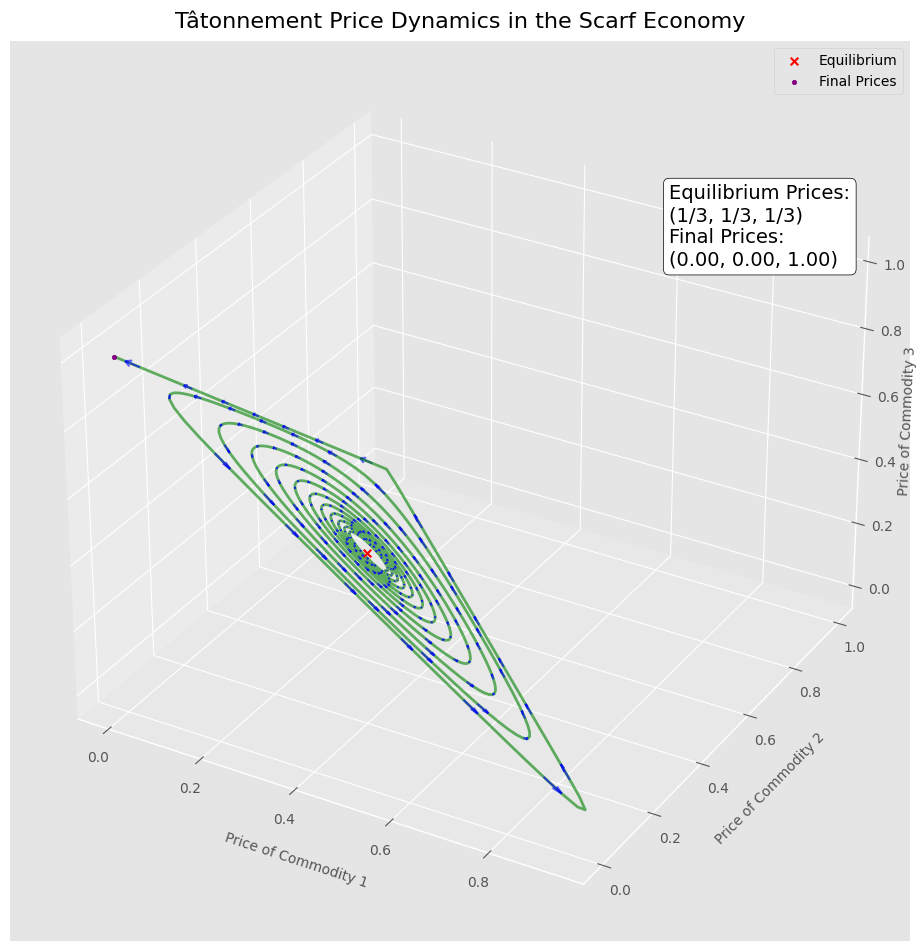

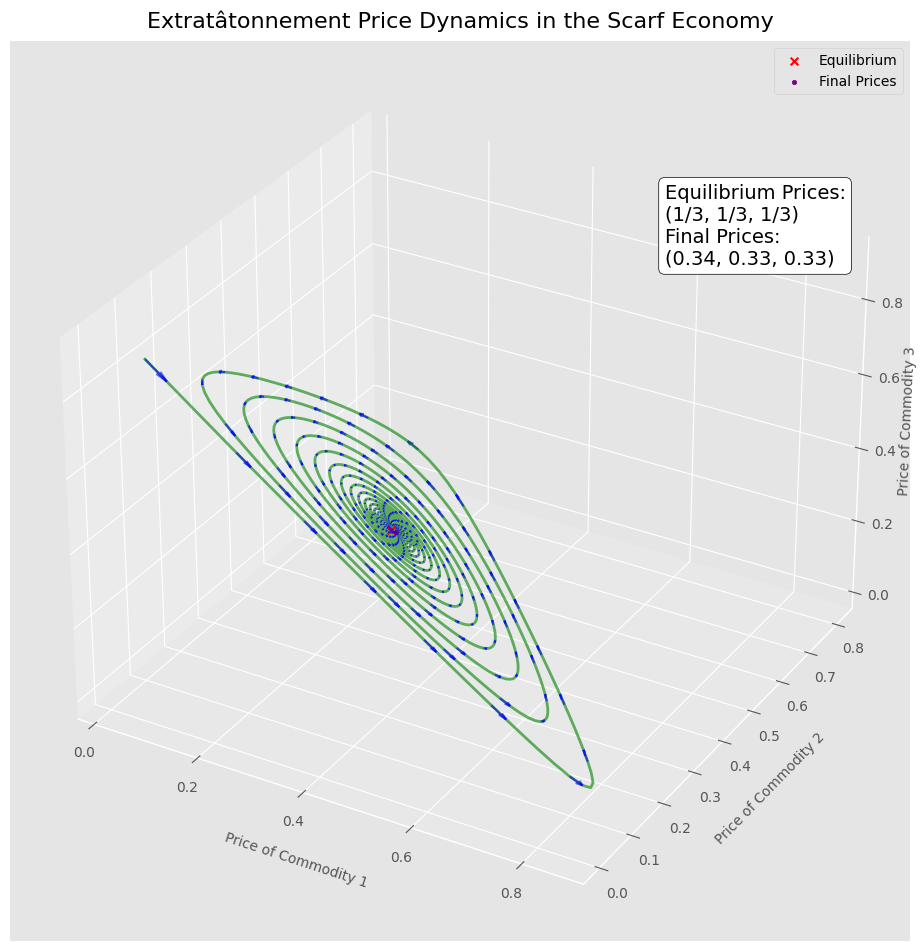

In [ ]:
plot_phase_portrait(tatonn_prices_histories, "Tâtonnement")
plot_phase_portrait(extratatonn_prices_histories, title = "Extratâtonnement")